In [1]:
import numpy as np
import pandas as pd
import rasterio
import pyproj
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from pysheds.grid import Grid

%matplotlib inline

# Generate grid and delineate catchment

In [2]:
grid = Grid.from_raster('../data/n30w100_con', data_name='dem')

grid.read_raster('../data/n30w100_dir', data_name='dir')

In [3]:
         #N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [4]:
# Specify pour point
x, y = -97.2937, 32.7371

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

In [5]:
grid.clip_to('catch', precision=5)

Unalignable bbox provided: [-97.4025   32.60667 -97.26167  32.73917].
Rounding to [-97.4025      32.60666667 -97.26166667  32.73916667]


In [6]:
catch = grid.view('catch')

# View data specified in different crs

In [7]:
grid.read_raster('../../../Data/GIS/nlcd_2011_impervious_2011_edition_2014_10_10/nlcd_2011_impervious_2011_edition_2014_10_10.img',
                 data_name='terrain', window=grid.bbox, window_crs=grid.crs)

In [8]:
# Grid CRS
grid.crs.srs

'+init=epsg:4326 '

In [9]:
# Terrain CRS
grid.terrain.crs.srs

'+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs=True '

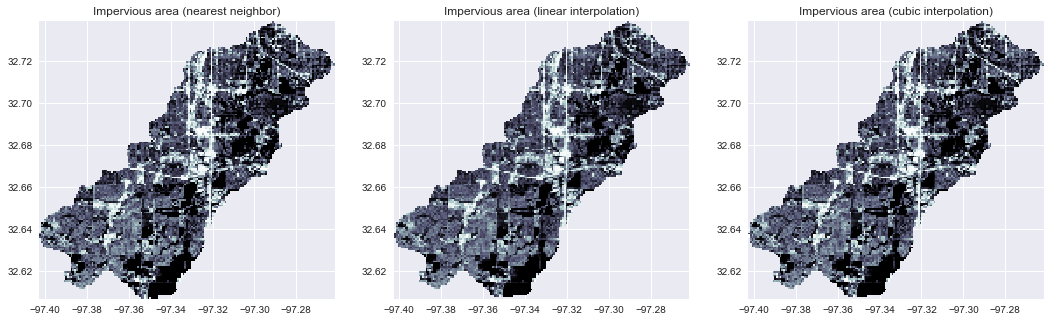

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].imshow(grid.view('terrain', dtype=np.float32), cmap='bone',
           extent=grid.extent, zorder=1, vmin=0, vmax=100)
ax[0].set_title('Impervious area (nearest neighbor)')
ax[1].imshow(grid.view('terrain', interpolation='linear', dtype=np.float32), cmap='bone',
           extent=grid.extent, zorder=1)
ax[1].set_title('Impervious area (linear interpolation)')
ax[2].imshow(grid.view('terrain', interpolation='cubic', dtype=np.float32), cmap='bone',
           extent=grid.extent, zorder=1, vmin=0, vmax=100)
ax[2].set_title('Impervious area (cubic interpolation)')

# Convert grid coordinate reference system

In [11]:
# WGS 84: Geographic
old_crs = pyproj.Proj('+init=epsg:4326')

# NAD83 / Texas Centric Albers Equal Area: Projected
new_crs = pyproj.Proj('+init=epsg:3083')

In [12]:
projected_catch, projected_coords = grid.view('catch', as_crs=new_crs, return_coords=True)

# View catchment in converted CRS

In [13]:
# Make sure grid elements are still the same
np.allclose(catch, projected_catch)

True

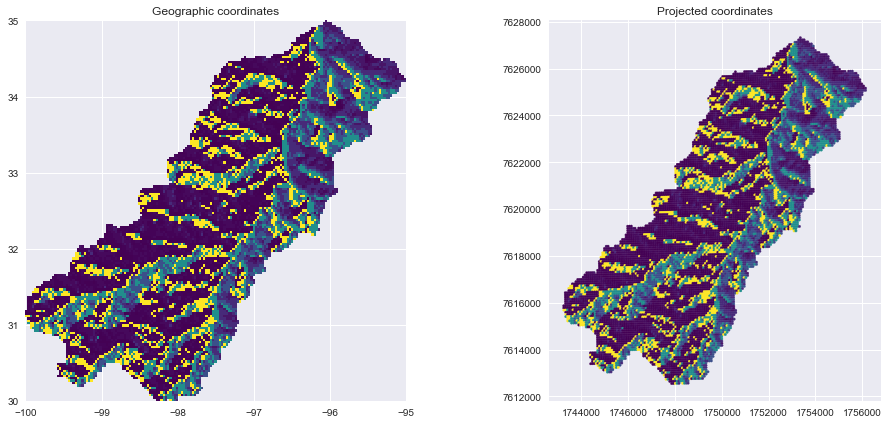

In [14]:
# Plot the catchment
image_arr = np.where(catch, catch, np.nan)
image_arr2 = projected_catch[projected_catch != 0]
y = projected_coords[:, 0][(projected_catch != 0).ravel()]
x = projected_coords[:, 1][(projected_catch != 0).ravel()]

fig, ax = plt.subplots(1, 2, figsize=(14,6))

plt.grid('on', zorder=0)
bbox = grid.catch.bbox
extent = (bbox[0], bbox[2], bbox[1], bbox[3])
im = ax[0].imshow(image_arr, extent=extent, zorder=1, cmap='viridis')
ax[0].set_title('Geographic coordinates')
ax[0].set_aspect('equal')

ax[1].set_aspect('equal')
sc = ax[1].scatter(x, y, c=image_arr2.ravel(), s=6, cmap='viridis')
ax[1].set_title('Projected coordinates')

plt.tight_layout()